In [5]:
import numpy as np
from IPython.display import Image,display

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Waves on a String

/home/nurul/dedalus/examples/evp_1d_waves_on_a_string

2023-04-26 13:07:10,828 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s


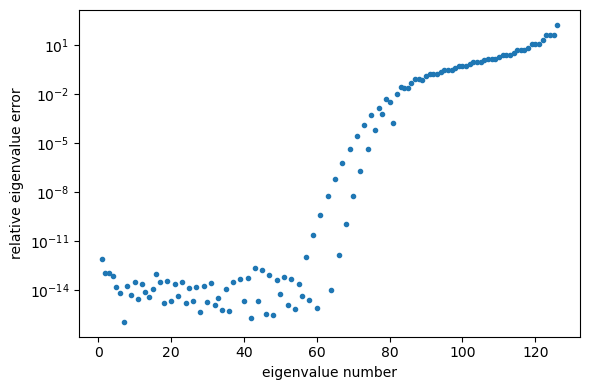

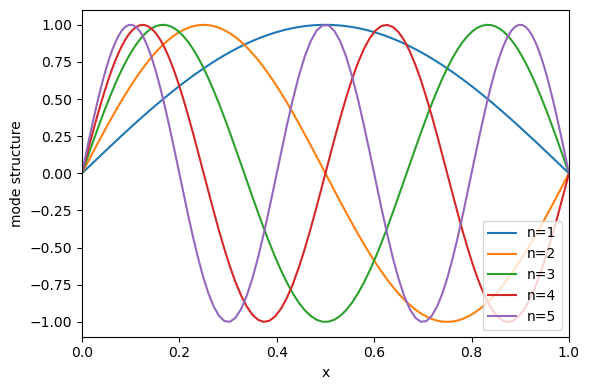

In [7]:
"""
Dedalus script computing the eigenmodes of waves on a clamped string.
This script demonstrates solving a 1D eigenvalue problem and produces
plots of the first few eigenmodes and the relative error of the eigenvalues.
It should take just a few seconds to run (serial only).

We use a Legendre basis to solve the EVP:
    s*u + dx(dx(u)) = 0
    u(x=0) = 0
    u(x=Lx) = 0
where s is the eigenvalue.

For the second derivative on a closed interval, we need two tau terms.
Here we choose to use a first-order formulation, putting one tau term
on an auxiliary first-order variable and another in the PDE, and lifting
both to the first derivative basis.

To run and plot:
    $ python3 waves_on_a_string.py
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)


# Parameters
Lx = 1
Nx = 128
dtype = np.complex128

# Bases
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=dtype)
xbasis = d3.Legendre(xcoord, size=Nx, bounds=(0, Lx))

# Fields
u = dist.Field(name='u', bases=xbasis)
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
s = dist.Field(name='s')

# Substitutions
dx = lambda A: d3.Differentiate(A, xcoord)
lift_basis = xbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
ux = dx(u) + lift(tau_1) # First-order reduction
uxx = dx(ux) + lift(tau_2)

# Problem
problem = d3.EVP([u, tau_1, tau_2], eigenvalue=s, namespace=locals())
problem.add_equation("s*u + uxx = 0")
problem.add_equation("u(x=0) = 0")
problem.add_equation("u(x=Lx) = 0")

# Solve
solver = problem.build_solver()
solver.solve_dense(solver.subproblems[0])
evals = np.sort(solver.eigenvalues)
n = 1 + np.arange(evals.size)
true_evals = (n * np.pi / Lx)**2
relative_error = np.abs(evals - true_evals) / true_evals

# Plot
plt.figure(figsize=(6, 4))
plt.semilogy(n, relative_error, '.')
plt.xlabel("eigenvalue number")
plt.ylabel("relative eigenvalue error")
plt.tight_layout()
plt.savefig("eigenvalue_error.pdf")
plt.savefig("eigenvalue_error.png", dpi=200)

plt.figure(figsize=(6, 4))
x = dist.local_grid(xbasis)
for n, idx in enumerate(np.argsort(solver.eigenvalues)[:5], start=1):
    solver.set_state(idx, solver.subsystems[0])
    ug = (u['g'] / u['g'][1]).real
    plt.plot(x, ug/np.max(np.abs(ug)), label=f"n={n}")
plt.xlim(0, 1)
plt.legend(loc="lower right")
plt.ylabel(r"mode structure")
plt.xlabel(r"x")
plt.tight_layout()
plt.savefig("eigenvectors.pdf")
plt.savefig("eigenvectors.png", dpi=200)